In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

In [ ]:
os.chdir("/mnt/")


In [12]:
!git clone https://github.com/Annaantonin/Data.git

Cloning into 'Data'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 15 (delta 2), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (15/15), 379.76 KiB | 10.85 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [10]:
# rm -rf Data

In [13]:
import Data as data
data = sio.loadmat("Data/sdof_2000.mat")

In [ ]:
!git clone https://github.com/Crunch-UQ4MI/neuraluq.git
#!git clone https://github.com/Annaantonin/Data.git
!pip install tensorflow-probability
!pip install scipy
import os
os.chdir("/tf/neuraluq/")
!python setup.py install

In [9]:
os.listdir(".")

['dataset',
 'README.md',
 'dist',
 'build',
 'output.mat',
 'examples',
 'NeuralUQ.egg-info',
 'output_ukF.mat',
 '.git',
 'setup.py',
 'Data',
 'neuraluq']

In [50]:
import neuraluq as neuq
import neuraluq.variables as neuq_vars
from neuraluq.config import tf

import numpy as np
import scipy.io as sio
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [69]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct  4 16:14:30 2023

@author: Antonina
"""

#%%
# Simulated SDOF with:
#K_true=5;
# C_true=0.2236; %system damping ratio 5%

# m=5; %mass for sdof example

def load_data(noise_x, noise_f):

    #data = sio.loadmat(r"G:\My Drive\Python_codes\NNs\sdof_ymeas.mat")
    data = sio.loadmat("Data/sdof_2000.mat")
    #  t_x_train, t_f_train = data["t"], data["ymeas"]
    # data = matdata['data']
    
    x_tt_train, t_train = data["a"], data["t"]
    x_train, f_train = data["u"], data["force"]
    # train_x_tt = t_x_tt_train, x_train
    # train_f = t_f_train, f_train

    return  x_tt_train.T, t_train.T, x_train.T, f_train.T

#m=1
# [0][..., 0:1]     

def pde_fn(t, x, log_c, log_k):
    # log_k=tf.clip(np.log(3),np.log(20)) # to make constrains for the parameters
    x_t = tf.gradients(x, t)                                                                                                                                                                                                                            
    x_tt = tf.gradients(x_t, t)

    f = tf.multiply(x_tt, 5.0)+ tf.exp(log_c) * x_t + tf.exp(log_k) * x

    # return [f,x_tt]
    return f

def pde_xtt(t,x):
    x_t = tf.gradients(x, t)                                                                                                                                                                                                                        
    x_tt = tf.gradients(x_t, t)
    
    return x_tt
    

@neuq.utils.timer
def Trainable(
    x_tt_train, t_train, x_train, f_train, noise, layers, 
):
    # build processes
    
    process_x = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        # surrogate=neuq.surrogates.FNN(layers=layers,activation=RELu),
        # posterior=neuq_vars.fnn.Trainable(layers=layers),# displacement
    # )
         posterior=neuq_vars.fnn.Trainable(
            layers=layers, regularizer=tf.keras.regularizers.l2(1e-5)
        ),
    )
    process_log_c = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    process_log_k = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    method = neuq.inferences.DEns(
        num_samples=1, num_iterations=20000, optimizer=tf.train.AdamOptimizer(1e-3),
    )

    # build losses
    loss_x = neuq.likelihoods.MSE(
        inputs=t_train,
        targets=x_tt_train, # could be the problem
        processes=[process_x],
        pde=pde_xtt, # dotdot _X
        multiplier=1.0,
    )
    
    loss_f = neuq.likelihoods.MSE(
        inputs=t_train,
        targets=f_train, 
        processes=[process_x, process_log_c, process_log_k], # tf train
        pde=pde_fn,
        multiplier=1.0,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_x, process_log_c, process_log_k],
        likelihoods=[loss_x, loss_f],
    )
    # assign and compile method
    model.compile(method)
    # obtain posterior samples
    samples = model.run()
    # samples,results = model.run()
    # print("Acceptance rate: %.3f \n" % (np.mean(results)))
    
    processes = [process_x, process_log_c, process_log_k]
    return processes, samples, model


if __name__ == "__main__":

    noise = 0

    x_tt_train, t_train, x_train, f_train = load_data(noise, noise)

    # t_x_tt_train, x_tt_train = train_x_tt
    # t_f_train, f_train = train_f

    layers = [1, 128, 128,  1]

    processes, samples, model = Trainable(
        x_tt_train, t_train, x_train, f_train, noise, layers,
    )

    x_pred, logc_pred, logk_pred = model.predict(t_train, samples, processes, pde_fn=None)


Supporting backend tensorflow.compat.v1

Compiling a Ensemble method

Generating 0th sample by deep ensemble...


2023-10-19 20:14:37.506855: W tensorflow/c/c_api.cc:305] Operation '{name:'Variable_291/Assign' id:34110 op device:{requested: '', assigned: ''} def:{{{node Variable_291/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](Variable_291, Const_487)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  1867.365
Iteration:  1000 , loss:  1361.4196
Iteration:  2000 , loss:  1211.2582
Iteration:  3000 , loss:  1181.6886
Iteration:  4000 , loss:  1166.6079
Iteration:  5000 , loss:  1150.9167
Iteration:  6000 , loss:  1115.1749
Iteration:  7000 , loss:  1096.9624
Iteration:  8000 , loss:  995.1319
Iteration:  9000 , loss:  981.1296
Iteration:  10000 , loss:  977.7097
Iteration:  11000 , loss:  974.79736
Iteration:  12000 , loss:  970.9005
Iteration:  13000 , loss:  962.1341
Iteration:  14000 , loss:  943.895
Iteration:  15000 , loss:  927.7573
Iteration:  16000 , loss:  920.3591
Iteration:  17000 , loss:  917.39014
Iteration:  18000 , loss:  915.49963
Iteration:  19000 , loss:  913.9558
Execution time for 'Trainable' function is: 174.069 s, 2.901 mins


In [62]:
[a.shape for a in samples]

[(1, 1, 64),
 (1, 64, 128),
 (1, 128, 128),
 (1, 128, 1),
 (1, 1, 64),
 (1, 1, 128),
 (1, 1, 128),
 (1, 1, 1),
 (1,),
 (1,)]

In [45]:
# x_pred, logc_pred, logk_pred = model.predict(t_train, samples, processes, pde_fn=None)
x_pred, logc_pred, logk_pred = model.predict(t_train, samples, processes, pde_fn=pde_fn)

ValueError: not enough values to unpack (expected 3, got 1)

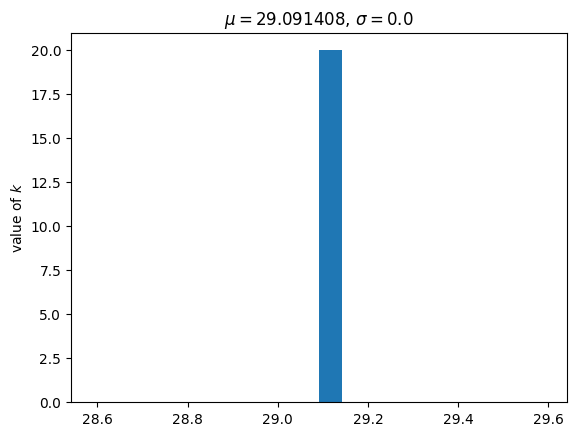

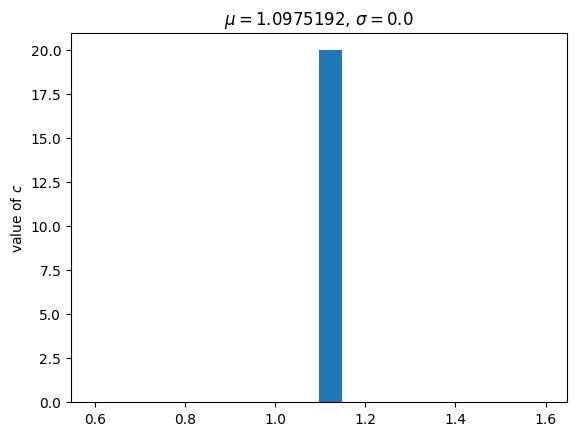

In [70]:
neuq.utils.hist(np.exp(logk_pred).flatten(), name="value of $k$")
neuq.utils.hist(np.exp(logc_pred).flatten(), name="value of $c$")

In [30]:
Csamp=samples[6]    
Ksamp=samples[7]
C_post=np.exp(np.mean(Csamp))
print("C_true=0.22(Ns/m) and C_post =", C_post) 
K_post=np.exp(np.mean(Ksamp))
print("K_true=10(N/m) and K_post =", K_post) 


C_true=0.22(Ns/m) and C_post = 0.99333316
K_true=10(N/m) and K_post = 0.9982925


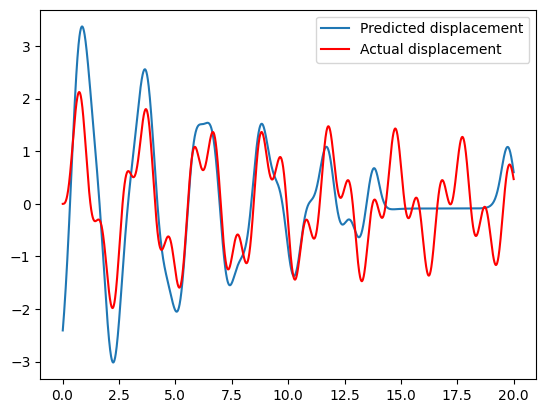

In [71]:
plt.plot(t_train,np.mean(x_pred,axis=(0, 2)),label='Predicted displacement')
plt.plot(t_train,x_train,'r',label='Actual displacement')
plt.legend()

In [ ]:
# sio.savemat("G:/My Drive/Python_codes/sdof0.mat", {"x_pred":x_pred, "k":samples[7].flatten(),"c":samples[6].flatten()})

In [31]:
data_to_save = {
   "x_pred":x_pred, "c":samples[6].flatten(),"k":samples[7].flatten()
}
file_name = 'output.mat'
sio.savemat(file_name, data_to_save)